In [51]:
import mne
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from stormdb.access import Query
from pickle import load
from scipy import stats
from mne.datasets import sample
from mne.stats import spatio_temporal_cluster_1samp_test
import os
from os import path as op
import pickle
from copy import deepcopy
import warnings
import src.group_stats as gs
import src.decoding_functions as df
import importlib
importlib.reload(gs)
importlib.reload(df)
from do_stats import do_stats
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [30]:
# Set directories
project = 'MINDLAB2020_MEG-AuditoryPatternRecognition'
project_dir = '/projects/' + project
stats_dir = project_dir + '/scratch/working_memory/results/stats/'
figures_dir = project_dir + '/scratch/working_memory/results/figures/'
dem_file = project_dir + '/misc/WM_demographics.csv'

In [83]:
subs = np.arange(11,91) 
exclude = np.array([55,60,73,82])
block, mode = 'localizer', 'sensor'
pars = 'lf_0.05_hf_None_tstep_0.025_twin_0.05'
rois = ['']#,'rA1_lA1','rThal_lThal','rHC_lHC', 'rPCC_lPCC', 'rPCN_lPCN']
sdata, scodes, times = gs.load_scores_compare(block, mode, pars, subs, rois, exclude)

loading subject 11 roi 
loading subject 12 roi 
loading subject 13 roi 
loading subject 14 roi 
loading subject 15 roi 
loading subject 16 roi 
loading subject 17 roi 
loading subject 18 roi 
loading subject 19 roi 
loading subject 20 roi 
loading subject 21 roi 
loading subject 22 roi 
loading subject 23 roi 
loading subject 24 roi 
loading subject 25 roi 
loading subject 26 roi 
loading subject 27 roi 
loading subject 28 roi 
loading subject 29 roi 
loading subject 30 roi 
loading subject 31 roi 
loading subject 32 roi 
could not load subject 0032_BLF roi 
[Errno 2] No such file or directory: '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages/data/0032_BLF/0032_BLF_scores_localizer_sensor_lf_0.05_hf_None_tstep_0.025_twin_0.05.p'
loading subject 33 roi 
could not load subject 0033_MXJ roi 
[Errno 2] No such file or directory: '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages/data/0033_MXJ/0033_MXJ_scores_localizer_

In [84]:
 smean, sstd, sci_lower, sci_upper, smedian, siqr_lower, siqr_upper = gs.grand_avg_scores(sdata)

In [85]:
CI = {ss: {'lower': sci_lower[ss], 'upper': sci_upper[ss]} for ss in sci_lower}

In [65]:
subtractions = [['rPCC_lPCC', '']]#,['rA1_lA1', 'rHC_lHC']]
conds = ['maintenance_from_maintenance','manipulation_from_manipulation']
difdata, difcodes = {}, {}
for c in conds:
    for st in subtractions:
        if len(st[0])>0:
            sub1 = '_include_' + st[0]
        else:
            sub1 = st[0]
        if len(st[1])>0:
            sub2 = '_include_' + st[1]
        else:
            sub2 = st[1]
        sidx1 = [s in scodes[c + sub2] for s in scodes[c + sub1]]
        sidx2 = [s in scodes[c + sub1] for s in scodes[c + sub2]]
        difdata[c + sub1 + '_' + sub2] = sdata[c + sub1][sidx1] - sdata[c+sub2][sidx2]
        difcodes[c + sub1 + '_' + sub2] = scodes[c + sub1][sidx1]

In [60]:
FDR_difstats = {s: gs.do_stats(difdata[s],'FDR',h0 = 0) for s in difdata}
difmasks     = {sm: FDR_difstats[sm]['mask'] for sm in FDR_difstats}


Performing FDR correction

26568

Performing FDR correction

26569

Performing FDR correction

26569

Performing FDR correction

26569


In [66]:
dif_cluster_stats = {}
for s in difdata:
    print('doing stats for {}'.format(s))
    dif_cluster_stats[s] = do_stats(difdata[s],method='montecarlo',h0=0,n_permutations=2000)

doing stats for maintenance_from_maintenance_include_rPCC_lPCC_
Clustering.
stat_fun(H1): min=-5.455458 max=4.174926
Running initial clustering
Found 956 clusters
Permuting 1999 times...


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
doing stats for manipulation_from_manipulation_include_rPCC_lPCC_
Clustering.
stat_fun(H1): min=-5.149019 max=4.618634
Running initial clustering
Found 1004 clusters
Permuting 1999 times...


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [67]:
dif_cluster_masks = {sm: dif_cluster_stats[sm]['mask'] for sm in dif_cluster_stats}

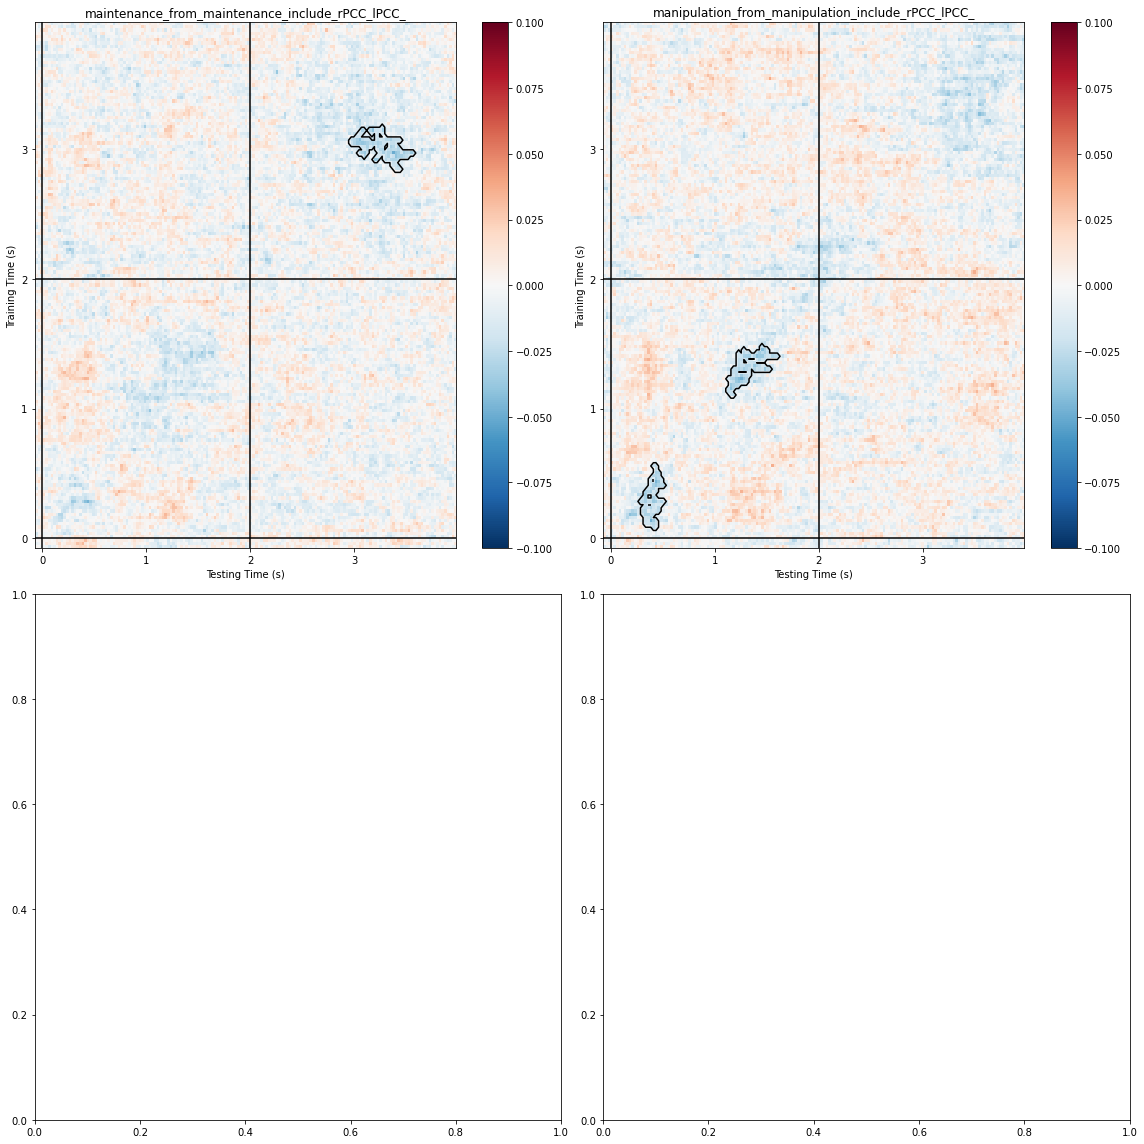

In [68]:
df.plot_time_gen_accuracy({s: dif_cluster_stats[s]['data_mean'] for s in dif_cluster_stats},
                          times,  masks = dif_cluster_masks,
                          nrows=2, ncols=2, vlines=[2], hlines=[2],
                          savefig=None, vmin=-.1,vmax=.1)

In [88]:
FDR_stats = {s: gs.do_stats(sdata[s],'FDR',h0 = 1/3) for s in sdata}
masks     = {sm: FDR_stats[sm]['mask'] for sm in FDR_stats}


Performing FDR correction

3409


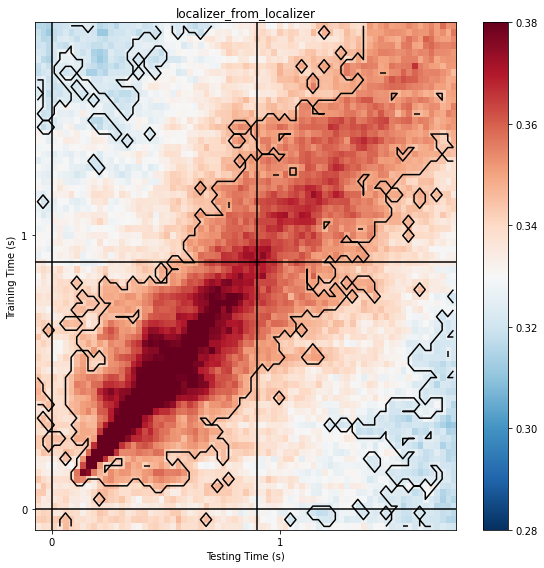

In [89]:
df.plot_time_gen_accuracy(smean, times,  masks = masks,
                          nrows=1, ncols=1, vlines=[.9], hlines=[.9],
                          savefig=None, vmin=.28,vmax=.38)

In [90]:
cluster_stats = {}
for s in sdata:
    print('doing stats for {}'.format(s))
    cluster_stats[s] = do_stats(sdata[s],method='montecarlo',h0=1/3,n_permutations=2000)

doing stats for localizer_from_localizer
Clustering.
stat_fun(H1): min=-6.201600 max=13.380956
Running initial clustering
Found 93 clusters
Permuting 1999 times...


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [91]:
cluster_masks = {sm: cluster_stats[sm]['mask'] for sm in cluster_stats}

/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scripts/working_memory/src/decoding_functions.py:215: UserWarning: No contour levels were found within the data range.
  cax.contour(masks[s].copy().astype('float'), levels=[-.1,1], colors='k',


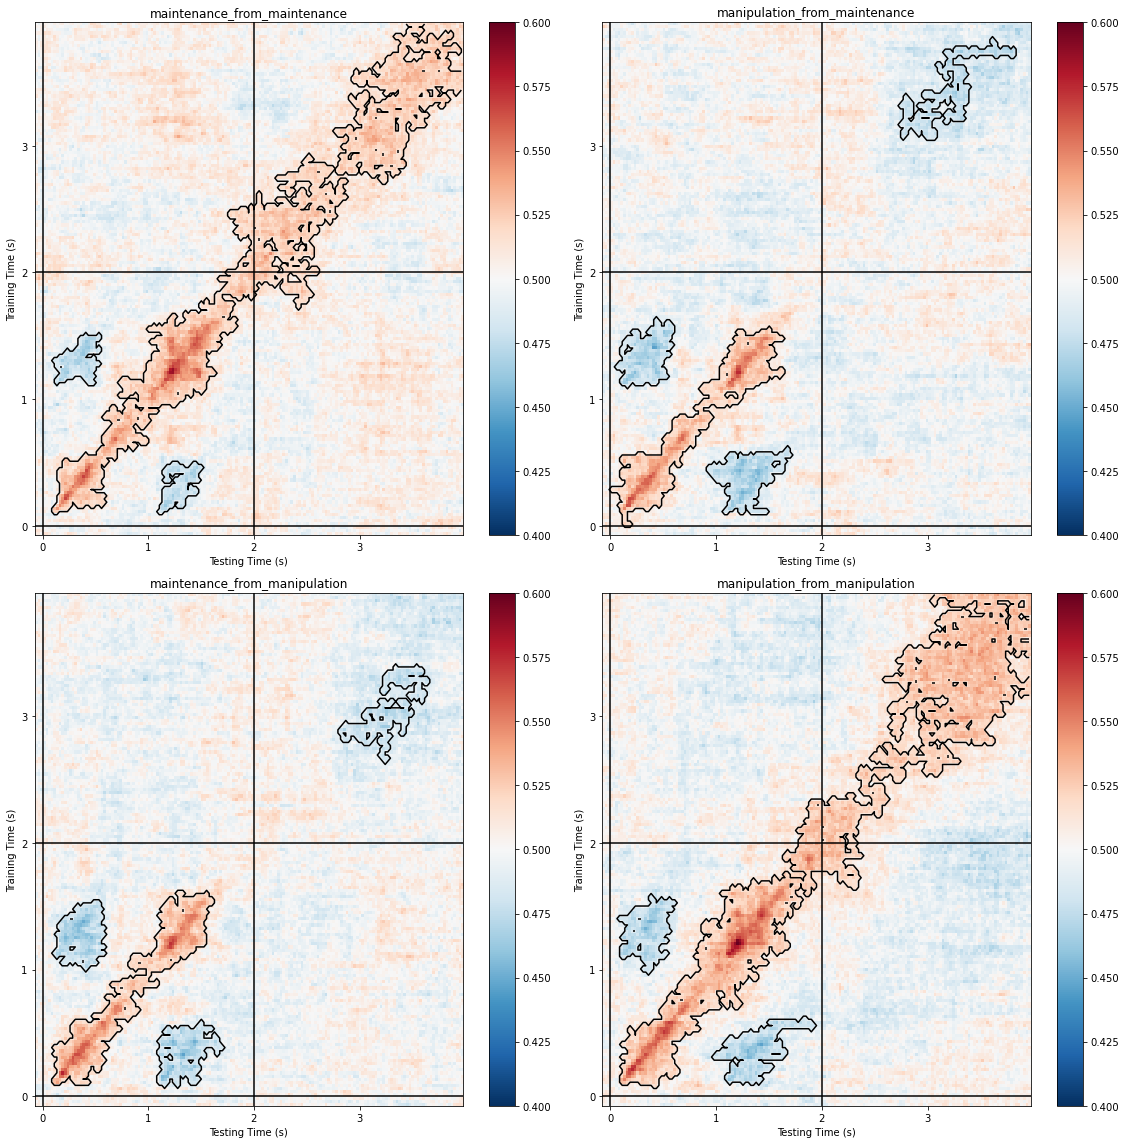

In [81]:
df.plot_time_gen_accuracy(smean, times,  masks = cluster_masks,
                          nrows=1, ncols=1, vlines=[.9], hlines=[.9],
                          savefig=None, vmin=.28,vmax=.38)

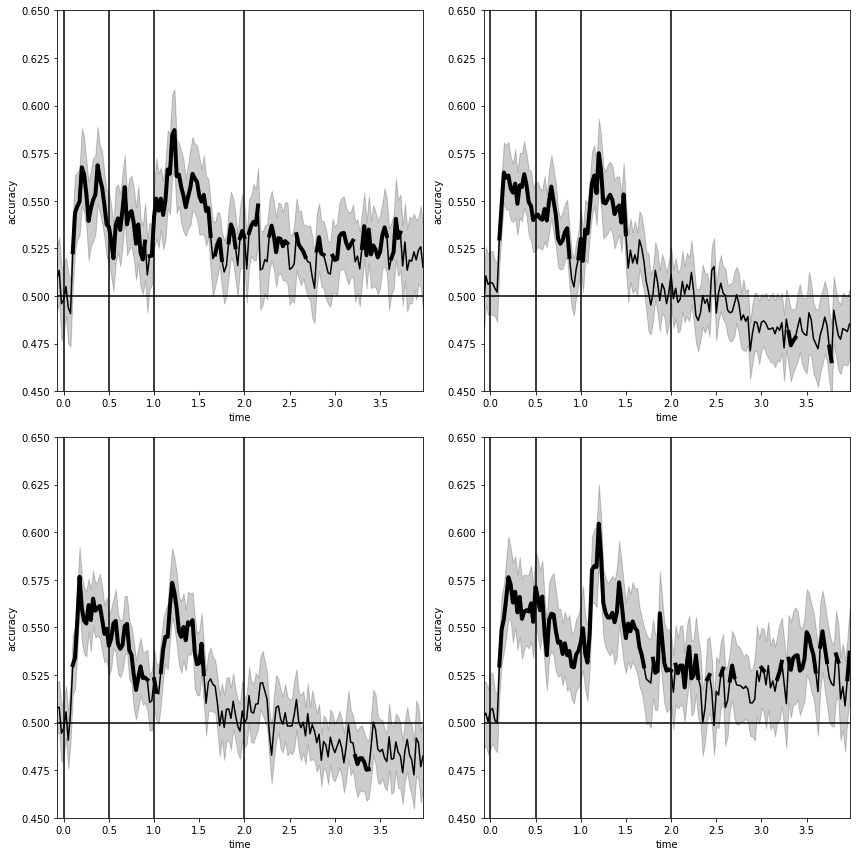

In [82]:
df.plot_diagonal_accuracy(smean, times,  masks = cluster_masks, CI=CI,
                          nrows=2, ncols=2, vlines=[.5,1,2], hlines=[],
                          savefig=None, ylims=(.45,.65), chance=1/2)

In [24]:
# load demographics
dem = pd.read_csv(dem_file)
dem = dem[np.isin(dem['Subject'],scodes)]
print(dem)

    Subject  Age Sex  vividness difficulty previous  musicianship  yomt
0        11   24   F        3.0          3       No           1.0  16.0
1        12   31   F        1.0          0      Yes           0.0   NaN
2        13   21   F        NaN          1      NaN           0.0   NaN
3        14   28   M        NaN          3      NaN           0.0   NaN
4        15   27   M        NaN          3      NaN           0.0   NaN
..      ...  ...  ..        ...        ...      ...           ...   ...
74       86   27   F        1.0          1      Yes           0.0   NaN
75       87   32   M        NaN        NaN      NaN           NaN   NaN
76       88   18   F        1.0         -1       No           0.0   NaN
77       89   20   F        2.0          2       No           1.0   7.0
78       90   36   F       -2.0          3       No           0.0   NaN

[70 rows x 8 columns]


In [ ]:
# Compute linear regression
betas, rval, reg_pvals, ci, aic = {},{},{},{},{}
preds = np.array([dem['vividness'],dem['musicianship']]).T
preds = sm.add_constant(preds)
print(preds.shape)
for s in sdata:
    cdata = np.array(sdata[s].copy()) - 1/3
    xshape = cdata.shape[1]
    yshape = cdata.shape[2]
    betas[s] = np.zeros((preds.shape[1],xshape,yshape))
    rval[s] = np.zeros((xshape,yshape))
    aic[s] = np.zeros((xshape,yshape))
    reg_pvals[s] = np.zeros((preds.shape[1],xshape,yshape))
    #ci[s] = np.zeros(betas[s].shape)
    for y in range(yshape):
        for x in range(xshape):
            print('regressing condition {} training sample: {}/{}, testing sample: {}/{}'.format(s,x,xshape,y,yshape))
            res = sm.OLS(cdata[:,x,y],preds,missing='drop').fit()
            betas[s][:,x,y] = res.params
            reg_pvals[s][:,x,y] = res.pvalues
            rval[s][x,y] = res.rsquared
            aic[s][x,y] = res.aic


In [ ]:
# compute correlations with vividness
pvals = {}
cors = {}
for s in sdata:
    sdata[s] = np.array(sdata[s])
    xshape = sdata[s].shape[1]
    yshape = sdata[s].shape[2]
    cors[s] = np.zeros((xshape,yshape))
    pvals[s] = np.zeros((xshape,yshape))
    for y in range(yshape):
        for x in range(xshape):
            print('correlating condition {} training sample: {}/{}, testing sample: {}/{}'.format(s,x,xshape,y,yshape))
            nanix = np.isnan(np.array(dem['vividness'])) == False
            #print(nanix)
#             cur_cor = np.array(pd.DataFrame({'a': sdata[s][:,x,y], 'b': np.array(dem['vividness'])}).corr())[0,1]
#             print(cur_cor)
            cors[s][x,y], pvals[s][x,y] = stats.pearsonr(sdata[s][nanix,x,y], np.array(dem['vividness'][nanix]))                   

In [ ]:
ncols = 2
fig, axes = plt.subplots(ncols=ncols,nrows=2, figsize = (20,13)) #,gridspec_kw=dict(width_ratios=[1,1,1,1]) )
for sidx,s in enumerate(cors):
    f,se = s.split('_from_')
    ext = [-.1,smean[s].shape[1] * .025,  
           -.1,smean[s].shape[0] * .025]
    rix, cix = sidx//ncols,sidx%ncols
    mask = pvals[s] <= .025
    im = axes[rix, cix].matshow(cors[s]*mask, vmin = -1, vmax = 1,#vmin=0.18, vmax=0.48,
                                      cmap='RdBu_r', origin='lower', extent=ext)
    axes[rix, cix].axhline(0., color='k')
    axes[rix, cix].axvline(0., color='k')
    axes[rix, cix].xaxis.set_ticks_position('bottom')
    axes[rix, cix].set_xlabel('Testing Time (s)')
    axes[rix, cix].set_ylabel('Training Time (s)')
    axes[rix, cix].set_anchor('W')
    axes[rix, cix].set_title('pred. {}'.format(s),{'horizontalalignment': 'center'})
cbar_ax = fig.add_axes([0.925,0.15,0.01,0.7])
fig.colorbar(im,cax=cbar_ax)
fig.suptitle('Vividness correlation', fontsize =  20)
plt.tight_layout()

In [ ]:
#plot musicians and nonmusicians
varnames = {'intercept': 0, 'vividness': 1, 'musicianship': 2}
ncols = 2
for ex in varnames:
    fig, axes = plt.subplots(ncols=ncols,nrows=2, figsize = (20,13)) #,gridspec_kw=dict(width_ratios=[1,1,1,1]) )
    for sidx,s in enumerate(betas):
        f,se = s.split('_from_')
        ext = [-.1,smean[s].shape[1] * .025,  
               -.1,smean[s].shape[0] * .025]
        rix, cix = sidx//ncols,sidx%ncols
        mask = reg_pvals[s][varnames[ex]] < .025
        im = axes[rix, cix].matshow(betas[s][varnames[ex]]*mask,# vmin = .4, vmax = .6,#vmin=0.18, vmax=0.48,
                                          cmap='RdBu_r', origin='lower', extent=ext)
        axes[rix, cix].axhline(0., color='k')
        axes[rix, cix].axvline(0., color='k')
        axes[rix, cix].xaxis.set_ticks_position('bottom')
        axes[rix, cix].set_xlabel('Testing Time (s)')
        axes[rix, cix].set_ylabel('Training Time (s)')
        axes[rix, cix].set_anchor('W')
        axes[rix, cix].set_title('pred. {}'.format(s),{'horizontalalignment': 'center'})
    cbar_ax = fig.add_axes([0.925,0.15,0.01,0.7])
    fig.colorbar(im,cax=cbar_ax)
    fig.suptitle('Decoding accuracy (ROC - AUC) {}'.format(ex), fontsize =  20)
    plt.tight_layout()
#plt.savefig(avg_path + '/figures/{}_accuracies_imagined.pdf'.format(sub),orientation='landscape')


In [ ]:
eix0 = np.array(dem['musicianship']) == 0
eix1 = np.array(dem['musicianship']) == 1
print(eix0)
print(eix1)
fig, axes = plt.subplots(ncols=ncols,nrows=4, figsize = (20,13)) #,gridspec_kw=dict(width_ratios=[1,1,1,1]) )
for sidx,s in enumerate(sdata):
    f,se = s.split('_from_')

    ext = [-.25,smean[s].shape[1] * .025 - 0.25,  
           -.25,smean[s].shape[0] * .025 - 0.25]
    rix, cix = sidx//ncols,sidx%ncols
    im = axes[rix, cix].matshow(sdata[s][eix1].mean(axis=0) - sdata[s][eix0].mean(axis=0), #vmin = .4, vmax = .6,#vmin=0.18, vmax=0.48,
                                      cmap='RdBu_r', origin='lower', extent=ext)
    axes[rix, cix].axhline(0., color='k')
    axes[rix, cix].axvline(0., color='k')
    axes[rix, cix].xaxis.set_ticks_position('bottom')
    axes[rix, cix].set_xlabel('Testing Time (s)')
    axes[rix, cix].set_ylabel('Training Time (s)')
    axes[rix, cix].set_anchor('W')
    axes[rix, cix].set_title('pred. {}'.format(s),{'horizontalalignment': 'center'})
cbar_ax = fig.add_axes([0.925,0.15,0.01,0.7])
fig.colorbar(im,cax=cbar_ax)
fig.suptitle('Decoding accuracy (ROC - AUC) musicians - non-musicians', fontsize =  20)
plt.tight_layout()